In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import scipy.stats as ss
import numpy.random as random
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

%matplotlib nbagg

np.random.seed(12345)

# Монте Карло методи в оптимизацията

### Какво са Монте Карло методите?



### Монте Карло методи за пресмятане на интеграли


- преформулираме задачата
$$I = \int f(x) dx = E[f(X)]=\int_{[0,1)^s} f(x) q(x) dx$$
- дефиниране на случайна величина или
	 случаен процес $X$, чието математическо очакване
	 съвпада с търсеното решение
$$\hat{I}(f)=\hat{I}_N=\frac{1}{N}\sum_{i=1}^N f(x_i)$$
- приближена оценка на статистическите
	 характерисики (дисперсия, очакване)
     

### Сходимост на Монте Карло методите


Ако $x_i$ са:
- случайни числа реда на сходимост е $O(N^{-1/2})$ независимо от размерността
- квази-случайни числа реда на сходимост е $O(N^{-1}(\log N)^s)$.

За първото твърдение използваме централната гранична теорема
$$\sigma^2= \mathrm{Var}(f(x))$$
$$
\sqrt{N} \frac{\hat{I}_N-I}{\sigma } \sim N(0,1)
$$

За квази случайни редици резултата следва от неравенството на Коксма-Хлавка:

$$ \left|\frac{1}{N}\sum_{i=1}^N f(x_i) - I(f)\right| \leq V(f) D_N^\star $$

$V$ е тоталната вариация на функцията. 

$D$ е дискрепанса на редицата, който в квази-случайния случай е $O(N^{-1}(\log N)^s)$$

<div class="image123">
    <img src="img/random.png" alt="Sobol" style="width: 400px;float:left"/>
    <img src="img/sobol.png" alt="Sobol" style="width: 400px;"/>
    <img src="img/faure.png" alt="Faure" style="width: 400px;"/>
</div>

### Проклятието на размерността

При високи размерности класическите алгоритми изпитват затруднения.

- броя точки, в който трябва да изчислим, ако размерността е голяма, е огромен

$$ N \approx (1/h)^s $$

Ако $s = 100$, $h=0.1$ , броя изчисления e 

$$10^{100}$$

Атомите във вселената - $10^{80}$



- при числено интегриране грешката на метода на трапците е 

$$ O(h^2) = O(N^{-2/s})  $$

Сравнено със сходимоста на Монте Карло методите, независещи от размерността

$$ O(N^{-1/2}) $$

виждаме, че при 

$$ s > 4 $$ асимптотичната сходимост е по-добра.

- в много приложения такива и значително по-големи размерности са нормални. Напремер при комбинаторни задачи, всяка променлива е отделна размерност.


# Имитирано охлаждане /Simulated Annealing/

- Оптимизационен алгоритъм подходящ за почти всяка функция

- Основава се на физическа аналогия при каляване на метали

- Няма математическо доказателство за сходимост /евристика/


#### Алгоритъм

- инициализираме алоритъма в избрана точка
- намираме нова "близка" точка
- ако функцията е по-малка в новата точка, преминаваме в нея
- ако е по-голяма, с вероятност P преминаваме в нея
- повтаряма, колкото стъпки сме задали

По аналогия с физическия процес на охлаждане
$$ P = \exp \left( \frac{-\Delta E}{kT}\right) $$

$$ \Delta E = f(x_{propsed}) - f(x_{current})$$

Свойства:

- $ P \to 0$ при  $T \to 0$
- $ P \to 1 $ при $\Delta E \to \infty $,T фиксирано

In [2]:
from math import exp

def text_log(sa, step, T):
    if(step % (sa.total_steps/10) == 0):
        print(str(step) + " T="+str(T) + "\tf(" + str(sa.x_current) + ") = " + str(sa.f_current))

In [3]:
def acceptance_rate(f_new, f_current, T, k=0.1):
    """ Physical cooling 
    """
    return exp(-(f_new - f_current)/k/T)

def cauchy(T, T_start, step, total_steps):
    return T/(step+1.0)

class SimulatedAnealing:
    """Simulated Annealing optimization
    """
    def __init__(self,
                 func,
                 init_state,
                 neighbor,
                 T=100.0,
                 total_steps=5000,  
                 acceptance=acceptance_rate,
                 cooling=cauchy,
                 logger = text_log): 
        self.func = func
        self.init_state = init_state
        self.neighbor = neighbor
        self.x_current = self.init_state
        self.f_current = self.func(*self.init_state)
        self.T_start = T
        self.acceptance=acceptance
        self.total_steps = total_steps
        self.cooling = cooling
        self.logger = logger
    
    
    def iteration(self, step, T):
        """one annealing step"""
        x_new = self.neighbor(self.x_current, T)
        f_new = self.func(*x_new)
        
        dE = f_new - self.f_current
        accept=False
        
        if(dE < 0):
            accept=True
        else:
            accept = random.random() < self.acceptance(f_new, self.f_current, T)
        
        if accept:
            self.x_current = x_new
            self.f_current = f_new            

    def anneal(self):
        """run the annealing"""
        T = self.T_start
        for step in range(self.total_steps):
            self.iteration(step, T)
            T = self.cooling(T, self.T_start, step, self.total_steps)
            self.logger(self, step, T)

В зависимост от задачата дефинираме:
- neighbor функция, която на текущата точка намира "близка" до нея
- acceptance критерий за приемане на новия кандидат. Тук може да се включат и ограничения за дефиниционната област
- cooling схема за "охлаждане", в зависимост, колко бързо и колко пълно искаме да обхождаме пространството

Дефинирайки тези функции напрактика получаваме алгоритъм специфично пригоден за задачата ни.

Никъде не сме поставили ограничения за дефиниционната област - може да бъде многомерна непрекъсната, дискретна и т.н.
Не сме поставили и изисквания за $f$ - не нужно да е гладка, непрекъсната или изпъкнала.

#### Непрекъснат пример:

<IPython.core.display.Javascript object>


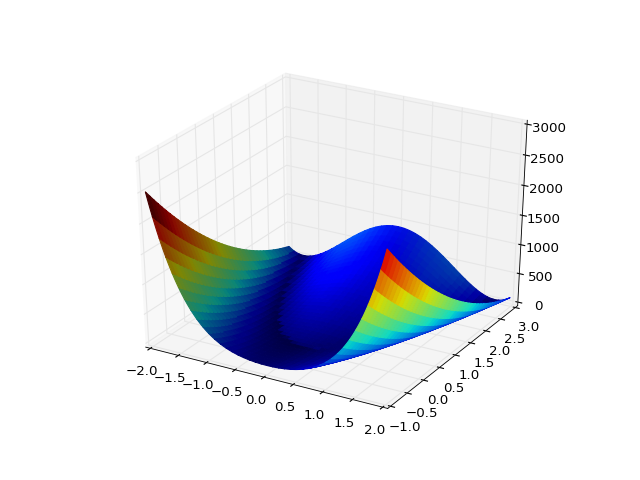

In [4]:
# define objective function: Rosenbrock function
def f(x1, x2):
    a=1
    b=100
    obj = (a-x1)**2+b*(x2-x1**2)**2
    return obj

# Start location
x_start = [0.8, 0.5]

# Design variables at mesh points
i1 = np.arange(-2, 2, 0.01)
i2 = np.arange(-1, 3, 0.01)
X, Y = np.meshgrid(i1, i2)
Z = f(X, Y)


fig = plt.figure()
ax = plt.axes(projection='3d')

Gx, Gy = np.gradient(Z) # gradients with respect to x and y
G = (Gx**2+Gy**2)**.5  # gradient magnitude
N = G/G.max()  # normalize 0..1

ax.plot_surface(X, Y, Z,facecolors=cm.jet(N))

plt.show()

In [7]:
x0 = np.array([0.1, 1.4])
   
def neighbor(x, T):
    #return x + random.uniform(-T, T, x.shape)
    return random.normal(x, max(T, 0.1), x.shape)

def cooling(T, T_start, step, total_steps):
    return T*0.99

sa = SimulatedAnealing(f, x0, neighbor, T=1, cooling=cooling, total_steps=1000)

sa.anneal()

print("Solution\tf(" + str(sa.x_current) + ") = " + str(sa.f_current))

0 T=0.99	f([ 0.1  1.4]) = 194.02
100 T=0.36237201786049694	f([ 0.76497533  0.59127383]) = 0.0589412291318
200 T=0.13263987810938213	f([ 0.99936973  0.99125278]) = 0.00560601717404
300 T=0.0485504851305729	f([ 1.01619597  1.02631872]) = 0.00427620993435
400 T=0.017771047742294682	f([ 0.99072175  0.98148858]) = 8.62540429041e-05
500 T=0.006504778211990459	f([ 1.01562429  1.02574243]) = 0.00355067843746
600 T=0.0023809591983979563	f([ 1.01846567  1.03969424]) = 0.000927545792766
700 T=0.0008715080698656353	f([ 1.00829228  1.01856465]) = 0.000434076036894
800 T=0.00031900013925143135	f([ 1.00829228  1.01856465]) = 0.000434076036894
900 T=0.00011676436783668758	f([ 1.00829228  1.01856465]) = 0.000434076036894
Solution	f([ 1.00829228  1.01856465]) = 0.000434076036894


- не знаем кога сме достигнали "достатъчно добро" решение, за това може да се наложи да изпълним няколко пъти алгоритъма
- обикновено при всяко следващо изпълнение се взима текущото решение за стартова точка.
- понякога се взимат много стартови точки и се изпълняват (паралелно) за намиране на най-добрия кандидат

<IPython.core.display.Javascript object>


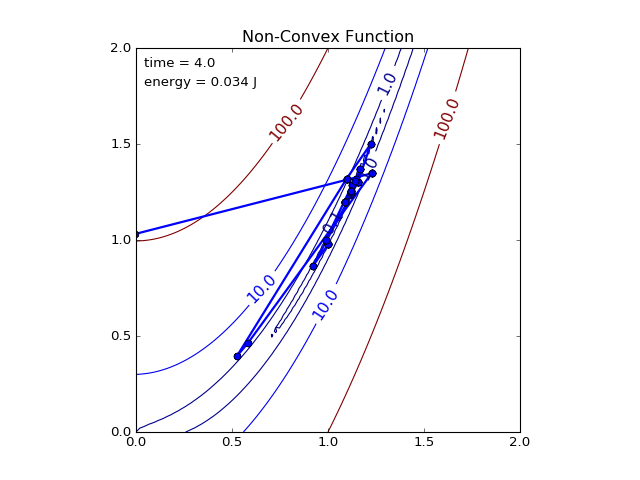

In [8]:
sa = SimulatedAnealing(f, x0, neighbor, T=1, cooling=cooling, total_steps=1000)

# set up figure and animation
fig = plt.figure()
xmin, xmax = 0.0, 2.0
ymin, ymax = 0.0, 2.0

x1 = np.linspace(xmin, xmax, 100)
x2 = np.linspace(ymin, ymax, 100)
Xc, Yc = np.meshgrid(x1, x2)
Zc = f(Xc, Yc)



ax = fig.add_subplot(111, aspect='equal', autoscale_on=False,
                     xlim=(xmin, xmax), ylim=(ymin, ymax))
CS = ax.contour(Xc, Yc, Zc, levels=[0, 0.1, 1, 10, 100])
ax.clabel(CS,           inline=1,           fmt='%1.1f',           fontsize=14)

ax.set_title('Non-Convex Function')

#ax.grid()

line, = ax.plot([], [], 'o-', lw=2)
time_text = ax.text(0.02, 0.95, '', transform=ax.transAxes)
energy_text = ax.text(0.02, 0.90, '', transform=ax.transAxes)

def init():
    """initialize animation"""
    line.set_data([], [])
    time_text.set_text('')
    energy_text.set_text('')
    return line, time_text, energy_text
T = sa.T_start
xs = []
ys = []
def animate(step):
    """perform animation step"""
    global sa, T, xs, ys
    sa.iteration(step, T)
    T = sa.cooling(T, sa.T_start, step, sa.total_steps) 
    xs.append(sa.x_current[0])
    ys.append(sa.x_current[1])
    print(xs)
    line.set_data(xs, ys)
    time_text.set_text('time = %.1f' % step)
    energy_text.set_text('energy = %.3f J' % T)
    return line, time_text, energy_text

# choose the interval based on dt and the time to animate one step


ani = animation.FuncAnimation(fig, animate, frames=10,
                              interval=100, init_func=init)

# save the animation as an mp4.  This requires ffmpeg or mencoder to be
# installed.  The extra_args ensure that the x264 codec is used, so that
# the video can be embedded in html5.  You may need to adjust this for
# your system: for more information, see
# http://matplotlib.sourceforge.net/api/animation_api.html
#ani.save('double_pendulum.mp4', fps=30, extra_args=['-vcodec', 'libx264'])


plt.show()

Недостатъци:
- както и при другите методи откритото решение може да е локален минимум 
- но обикновено стойността е близка до глобалния
- за малки размерности класическите градиентни методи дават по бърза сходимост

Предимства:
- няма нужда да се пресмята градиенти или повисоки производни
- няма изисквания за гладкост или изпъкнлост
- размерността на функцията не влиае на сходимостта

- лесно се адаптира към проблема 
- купища алгоритми доразвиват идеята:
 - генетични алгоритми
 - колонии от мвавки и пр.

![ 2006 NASA ST5 spacecraft antenna](img/220px-St_5-xband-antenna.jpg)

Антена за космически кораб. Оптималната форма е получена с генетичен алгоритъм.
    